In [1]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Loading data...
Epoch 1/100
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 314s 259ms/step - accuracy: 0.4864 - loss: 1.8848 - val_accuracy: 0.6595 - val_loss: 1.2801
Epoch 2/100
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 169s 165ms/step - accuracy: 0.6460 - loss: 1.1502 - val_accuracy: 0.6521 - val_loss: 1.2184
Epoch 3/100
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 169s 165ms/step - accuracy: 0.6720 - loss: 0.9659 - val_accuracy: 0.6873 - val_loss: 0.9319
Epoch 4/100
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 167s 163ms/step - accuracy: 0.6986 - loss: 0.8504 - val_accuracy: 0.6859 - val_loss: 0.9496
Epoch 5/100
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 169s 165ms/step - accuracy: 0.7120 - loss: 0.7879 - val_accuracy: 0.7026 - val_loss: 0.8327
Epoch 6/100
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 169s 165ms/step - accuracy: 0.7165 - loss: 0.7574 - val_accuracy: 0.7123 - val_loss: 0.7548
Epoch 7/100
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 169s 165ms/step - accuracy: 0.7267 - loss: 0.7249 - val_accuracy: 0.7242 - val_loss: 0.7512
Epoch 8/100
1024/1024 ━━━━━━━━━━━━━━━━━

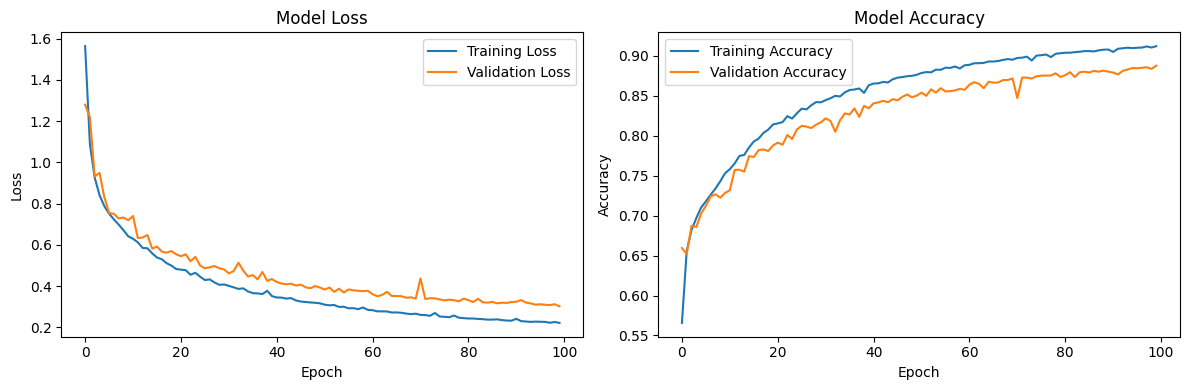

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2
import os
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Set GPU device

def get_unet(input_shape=(256, 256, 1), drop_rate=0.3, classes=11):
    inputs = Input(input_shape)
    
    # Encoder
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    batch1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(batch1_1)
    batch1_2 = BatchNormalization()(conv1_2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1_2)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    batch2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(batch2_1)
    batch2_2 = BatchNormalization()(conv2_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2_2)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    batch3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(batch3_1)
    batch3_2 = BatchNormalization()(conv3_2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3_2)

    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    batch4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(batch4_1)
    batch4_2 = BatchNormalization()(conv4_2)
    drop4 = Dropout(drop_rate)(batch4_2)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bridge
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    batch5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(batch5_1)
    batch5_2 = BatchNormalization()(conv5_2)
    drop5 = Dropout(drop_rate)(batch5_2)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6])
    conv6_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    batch6_1 = BatchNormalization()(conv6_1)
    conv6_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(batch6_1)
    batch6_2 = BatchNormalization()(conv6_2)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(batch6_2))
    merge7 = concatenate([batch3_2, up7])
    conv7_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    batch7_1 = BatchNormalization()(conv7_1)
    conv7_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(batch7_1)
    batch7_2 = BatchNormalization()(conv7_2)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(batch7_2))
    merge8 = concatenate([batch2_2, up8])
    conv8_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    batch8_1 = BatchNormalization()(conv8_1)
    conv8_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(batch8_1)
    batch8_2 = BatchNormalization()(conv8_2)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(batch8_2))
    merge9 = concatenate([batch1_2, up9])
    conv9_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    batch9_1 = BatchNormalization()(conv9_1)
    conv9_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(batch9_1)
    batch9_2 = BatchNormalization()(conv9_2)

    outputs = Conv2D(classes, 1, activation='softmax')(batch9_2)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])
    
    return model

class SARSegmentation:
    def __init__(self, img_rows=256, img_cols=256, drop_rate=0.5):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.drop_rate = drop_rate
        self.num_channels = 1  # Single-pol SAR
        self.model = None
        
        # ESA WorldCover class definitions
        self.class_definitions = {
            'trees': 10,
            'shrubland': 20,
            'grassland': 30,
            'cropland': 40,
            'built_up': 50,
            'bare': 60,
            'snow': 70,
            'water': 80,
            'wetland': 90,
            'mangroves': 95,
            'moss': 100
        }
        self.num_classes = len(self.class_definitions)

    def one_hot_encode(self, labels):
        """Convert ESA WorldCover labels to one-hot encoded format"""
        encoded = np.zeros((labels.shape[0], labels.shape[1], self.num_classes))
        
        for i, value in enumerate(sorted(self.class_definitions.values())):
            encoded[:, :, i] = (labels == value)
        
        return encoded

    def load_sar_data(self, file_path):
        """Load SAR data from various formats"""
        if file_path.endswith('.tif'):
            with rasterio.open(file_path) as src:
                sar_data = src.read(1)  # Read single band
                sar_data = np.expand_dims(sar_data, axis=-1)
                
                if sar_data.shape[:2] != (self.img_rows, self.img_cols):
                    sar_data = cv2.resize(sar_data, (self.img_cols, self.img_rows))
                    sar_data = np.expand_dims(sar_data, axis=-1)
                
                return sar_data
        else:
            raise ValueError(f"Unsupported file format for {file_path}")

    def preprocess_sar(self, sar_data):
        """Preprocess SAR data"""
        # Data is assumed to be in dB scale
        sar_clipped = np.clip(sar_data, -50, 20)
        sar_normalized = (sar_clipped - np.min(sar_clipped)) / (np.max(sar_clipped) - np.min(sar_clipped)) * 2 - 1
        return sar_normalized

    def load_data(self, sar_dir, label_dir):
        """Load all SAR and label data from directories"""
        sar_files = sorted([os.path.join(sar_dir, f) for f in os.listdir(sar_dir)
                          if f.endswith('.tif')])
        label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir)
                            if f.endswith('.tif')])
        
        assert len(sar_files) == len(label_files), "Number of SAR and label files must match"
        return sar_files, label_files

    def create_dataset(self, sar_files, label_files):
        """Create training dataset from files"""
        X = np.zeros((len(sar_files), self.img_rows, self.img_cols, self.num_channels))
        y = np.zeros((len(label_files), self.img_rows, self.img_cols, self.num_classes))

        for i, (sar_path, label_path) in enumerate(zip(sar_files, label_files)):
            print(f"Processing file {i+1}/{len(sar_files)}")
            
            # Load and preprocess SAR data
            sar_data = self.load_sar_data(sar_path)
            sar_processed = self.preprocess_sar(sar_data)
            X[i] = sar_processed

            # Load and process label
            with rasterio.open(label_path) as src:
                label = src.read(1)
                if label.shape != (self.img_rows, self.img_cols):
                    label = cv2.resize(label, (self.img_cols, self.img_rows), 
                                     interpolation=cv2.INTER_NEAREST)
                y[i] = self.one_hot_encode(label)

        return X, y

    # Memory optimizations for the training function
    def train(self, sar_dir, label_dir, validation_split=0.2, batch_size=4, epochs=100):
        print('Loading data...')
        sar_files, label_files = self.load_data(sar_dir, label_dir)
        
        # Split files first before loading data
        train_sar_files, val_sar_files, train_label_files, val_label_files = train_test_split(
            sar_files, label_files, test_size=validation_split, random_state=42
        )
        
        # Create data generator instead of loading all data at once
        def data_generator(sar_files, label_files, batch_size):
            while True:
                # Shuffle files each epoch
                indices = np.random.permutation(len(sar_files))
                for start in range(0, len(indices), batch_size):
                    batch_indices = indices[start:start + batch_size]
                    batch_x = np.zeros((len(batch_indices), self.img_rows, self.img_cols, self.num_channels))
                    batch_y = np.zeros((len(batch_indices), self.img_rows, self.img_cols, self.num_classes))
                    
                    for i, idx in enumerate(batch_indices):
                        sar_data = self.load_sar_data(sar_files[idx])
                        sar_processed = self.preprocess_sar(sar_data)
                        batch_x[i] = sar_processed
                        
                        with rasterio.open(label_files[idx]) as src:
                            label = src.read(1)
                            if label.shape != (self.img_rows, self.img_cols):
                                label = cv2.resize(label, (self.img_cols, self.img_rows), 
                                                interpolation=cv2.INTER_NEAREST)
                            batch_y[i] = self.one_hot_encode(label)
                    
                    yield batch_x, batch_y
        
        # Create generators
        train_generator = data_generator(train_sar_files, train_label_files, batch_size)
        val_generator = data_generator(val_sar_files, val_label_files, batch_size)
        
        # Calculate steps per epoch
        steps_per_epoch = len(train_sar_files) // batch_size
        validation_steps = len(val_sar_files) // batch_size
        
        # Initialize model with mixed precision
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        self.model = get_unet(
            input_shape=(self.img_rows, self.img_cols, self.num_channels),
            classes=self.num_classes
        )
        
        # Use memory-efficient callbacks
        callbacks = [
            ModelCheckpoint('weights/unet_best.weights.h5', 
                           monitor='val_loss',
                           save_best_only=True,
                           save_weights_only=True),
            EarlyStopping(patience=10, monitor='val_loss'),
        ]
        
        # Train with generators
        history = self.model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=validation_steps,
            callbacks=callbacks
        )

        
        return history


    def predict(self, sar_data):
        """Predict segmentation for new SAR data"""
        if self.model is None:
            raise ValueError("Model not trained. Call train() first or load a trained model.")
        
        # Preprocess input data
        sar_processed = self.preprocess_sar(sar_data)
        
        # Ensure correct shape
        if len(sar_processed.shape) == 3:
            sar_processed = np.expand_dims(sar_processed, axis=0)
        
        # Make prediction
        prediction = self.model.predict(sar_processed)
        return prediction

    def load_trained_model(self, model_path):
        """Load a trained model from file"""
        self.model = get_unet(
            input_shape=(self.img_rows, self.img_cols, self.num_channels),
            classes=self.num_classes
        )
        self.model.load_weights(model_path)

def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(121)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_prediction(prediction, original_sar=None):
    """Visualize segmentation prediction with ESA WorldCover colors"""
    # ESA WorldCover colors
    colors = {
        0: [0, 100, 0],     # Trees - Dark green
        1: [255, 165, 0],   # Shrubland - Orange
        2: [144, 238, 144], # Grassland - Light green
        3: [255, 255, 0],   # Cropland - Yellow
        4: [255, 0, 0],     # Built-up - Red
        5: [139, 69, 19],   # Bare - Brown
        6: [255, 255, 255], # Snow - White
        7: [0, 0, 255],     # Water - Blue
        8: [0, 139, 139],   # Wetland - Dark cyan
        9: [0, 255, 0],     # Mangroves - Bright green
        10: [220, 220, 220] # Moss - Light grey
    }
    
    # Convert prediction to color image
    pred_class = np.argmax(prediction[0], axis=-1)
    colored_pred = np.zeros((pred_class.shape[0], pred_class.shape[1], 3), dtype=np.uint8)
    
    for class_idx, color in colors.items():
        colored_pred[pred_class == class_idx] = color
    
    # Display
    plt.figure(figsize=(12, 4))
    
    if original_sar is not None:
        plt.subplot(131)
        plt.title('Original SAR')
        plt.imshow(original_sar[:,:,0], cmap='gray')
        plt.axis('off')
        
        plt.subplot(132)
        plt.title('Prediction')
        plt.imshow(colored_pred)
        plt.axis('off')
        
        plt.subplot(133)
        plt.title('Overlay')
        overlay = cv2.addWeighted(
            cv2.cvtColor(original_sar[:,:,0], cv2.COLOR_GRAY2RGB),
            0.7,
            colored_pred,
            0.3,
            0
        )
        plt.imshow(overlay)
        plt.axis('off')
    else:
        plt.imshow(colored_pred)
        plt.axis('off')
        plt.title('Prediction')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Initialize the segmentation model
    segmentation = SARSegmentation(
        img_rows=256,
        img_cols=256,
        drop_rate=0.5
    )
    
    # Train the model
    history = segmentation.train(
        sar_dir='/kaggle/input/hyd-slo-aug/sar_patches_augmented',
        label_dir='/kaggle/input/hyd-slo-aug/label_patches_augmented',
        validation_split=0.2,
        batch_size=4,
        epochs=100
    )
    
    # Plot training history
    plot_training_history(history)
    
    # For prediction on new data
    # Load new SAR data
    #new_sar_data = segmentation.load_sar_data('path/to/new/sar/data.tif')
    
    # Make prediction
    #prediction = segmentation.predict(new_sar_data)
    
    # Visualize results
    #visualize_prediction(prediction, new_sar_data)

